In [8]:
# Here we inplement seq2seq architecture LSTM for timeSeries prediction



In [ ]:
import pandas as pd
import numpy as np

import keras
from scipy import stats
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential, load_model, save_model

import datetime 
import seaborn as sns
from pylab import rcParams
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import time

import plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

import sqlalchemy

init_notebook_mode(connected=True)

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

WINDOW = 22

In [4]:
def connect(user, password, db, host: str, port: int, echo=True):
    url = 'postgresql+psycopg2://{}:{}@{}:{}/{}'
    url = url.format(user, password, host, port, db)
    eng = sqlalchemy.create_engine(url, client_encoding='utf8', echo=echo)
    meta = sqlalchemy.MetaData(bind=eng)
    return eng, meta

def get_data_frame(pair: str = 'USDT_BTC', exchange: str = 'poloniex') -> pd.DataFrame:

    engine, meta = connect(user='postgres', password='password', db='btccandles', host='94.230.125.199', port=16432)
    df = pd.read_sql_query(
        "SELECT date, time, open, close, low, high, volume, pair.\"name\""
        "FROM candlestick, pair WHERE candlestick.pair_id = pair.id AND pair.id IN ("
        "SELECT pair.id FROM pair, exchange WHERE ("
        "SELECT pair.id FROM pair WHERE pair.name = '" + pair +
        "') = pair.alias_id AND pair.exchange_id = (SELECT exchange.id FROM exchange WHERE exchange.\"name\" = '" + exchange + "')) ORDER BY candlestick.date;",
        con=engine)
    return df

In [75]:
def load_data(X, seq_len):
    train_size=0.95
    amount_of_features = X.shape[1] 
    X_mat = X.as_matrix() 
    
    sequence_length = seq_len + 1 
    data = []

    for index in range(len(X_mat) + 1 - sequence_length):
        data.append(X_mat[index: index + sequence_length])
    
    data = np.array(data)
    train_split = int(round(train_size * data.shape[0]))
    train_data = data[:train_split, :]
    
    x_train = train_data[:, :-1]
    y_train = train_data[:, -1][:,-1]
    
    x_test = data[train_split:, :-1] 
    y_test = data[train_split:, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return x_train, y_train, x_test, y_test

def seq2seq(layers):
        d = 0.3
        model = Sequential()
        model.add(LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=True))
        model.add(Dropout(d))
        
        model.add(LSTM(64, input_shape=(layers[1], layers[0]), return_sequences=False))
        model.add(Dropout(d))
        
        model.add(Dense(16, activation='relu'))         
        model.add(Dense(1, activation='linear'))
        
        model.compile(loss='mse',optimizer='rmsprop',metrics=['accuracy'])
        print("Compilation Time : ", time.time() - start)
        
        return model


In [76]:
from sklearn.preprocessing import MinMaxScaler

data = get_data_frame()
data = data[['open', 'high', 'close']]

x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

x = data[['open', 'high']].copy()
y = data['close'].copy()

x[['open', 'high']] = x_scaler.fit_transform(x)

y = y_scaler.fit_transform(y.values.reshape(-1, 1))
x['close'] = y

seq_length = 22

X_train, y_train, X_test, y_test = load_data(x, seq_length)

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)

print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

model = seq2seq([3, seq_length ,1])

2017-07-26 15:17:59,548 INFO sqlalchemy.engine.base.Engine select version()
2017-07-26 15:17:59,549 INFO sqlalchemy.engine.base.Engine {}
2017-07-26 15:17:59,550 INFO sqlalchemy.engine.base.Engine select current_schema()
2017-07-26 15:17:59,551 INFO sqlalchemy.engine.base.Engine {}
2017-07-26 15:17:59,553 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2017-07-26 15:17:59,553 INFO sqlalchemy.engine.base.Engine {}
2017-07-26 15:17:59,554 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2017-07-26 15:17:59,555 INFO sqlalchemy.engine.base.Engine {}
2017-07-26 15:17:59,556 INFO sqlalchemy.engine.base.Engine show standard_conforming_strings
2017-07-26 15:17:59,557 INFO sqlalchemy.engine.base.Engine {}
2017-07-26 15:17:59,558 INFO sqlalchemy.engine.base.Engine SELECT date, time, open, close, low, high, volume, pair."name"FROM candlestick, pair WHERE candlestick.pair_id = pair.id AND pair.id IN (SELEC

In [78]:
model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=100,
    validation_split=0.1,
    verbose=0)

/root/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/root/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/root/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/root/anaconda/lib/python3.6/site-packages/sklear

Train Score: 753602.24 RMSE
Train Score: 753602.24 RMSE
Expected value:  [ 2565.99999948]
Last Prediction:  [ 2326.08398438]


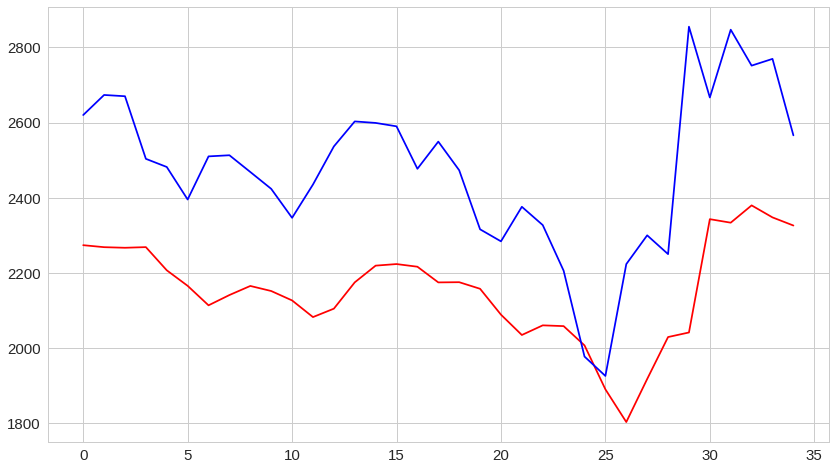

The Stock values have been plotted.


In [112]:
import math

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

trainScore = metrics.mean_squared_error(y_scaler.inverse_transform(y_train), \
                                        y_scaler.inverse_transform(train_predict) ** .5)
print('Train Score: %.2f RMSE' % (trainScore))

testScore = metrics.mean_squared_error(y_scaler.inverse_transform(y_test), \
                                        y_scaler.inverse_transform(test_predict) ** .5)
print('Train Score: %.2f RMSE' % (trainScore))
                            
    

window = 22
diff=[]
ratio=[]




for u in range(0, len(X_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))

import matplotlib.pyplot as plt2

print("Expected value: ",(y_scaler.inverse_transform([y_test[-1]])))
print("Last Prediction: ",(y_scaler.inverse_transform(p[-1])))
plt2.plot(y_scaler.inverse_transform(p) ,color='red', label='prediction')
plt2.plot(y_scaler.inverse_transform(y_test) ,color='blue', label='y_test')
plt2.show()

print("The Stock values have been plotted.")
